In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import scqubits as qubit
import scqubits.utils.sweep_plotting as splot
from scqubits.core.hilbert_space import HilbertSpace, InteractionTerm
from scqubits.core.param_sweep import ParameterSweep

import numpy as np
import qutip as qt

# Composite Hilbert Spaces, QuTiP Interface

The `HilbertSpace` class provides data structures and methods for handling composite Hilbert spaces which may consist of multiple qubits or qubits and oscillators coupled to each other. To harness the power of QuTiP, a toolbox for studying stationary and dynamical properties of closed and open quantum systems (and much more), `HilbertSpace` provides a convenient interface: it generates `qutip.qobj` objects which are then directly handled by QuTiP.

## Example: two transmons coupled to a harmonic mode

Transmon qubits can be capacitively coupled to a common harmonic mode, realized by an LC oscillator or a transmission-line resonator. The Hamiltonian describing such a composite system is given by:
\begin{equation}
H=\sum_{\alpha=1,2}\sum_{j} E_j^{(\alpha)}|\alpha j\rangle\langle \alpha j| + \omega_r a^\dagger a + \sum_{\alpha=1,2}g^{(\alpha)} n_\alpha(a+a^\dagger),
\end{equation}
where $\alpha=1,2$ enumerates the two transmon systems. The eigenenergies of the two transmon qubits are denoted $E_j^\alpha$, $\omega_r$ is the (angular) frequency of the resonator, and $n_\alpha$ is the charge number operator for qubit $\alpha$.

### Create Hilbert space components

The first step consists of creating the objects describing the building blocks of the full Hilbert space. Here, these will be two transmons and an oscillator:

In [2]:
tmon1 = qubit.Transmon(
    EJ = 40.0,
    EC = 0.2,
    ng = 0.3,
    ncut = 40,
    truncated_dim = 4     # after diagonalization, we will keep 3 levels
)

tmon2 = qubit.Transmon(
    EJ = 15.0,
    EC = 0.15,
    ng = 0.0,
    ncut = 30,
    truncated_dim = 4
)

resonator = qubit.Oscillator(
    omega = 4.5,
    truncated_dim=4  # up to 3 photons (0,1,2,3)
)

The system objects are grouped into a Python list and in this form used for the creation and initialization of a `HilbertSpace` instance. Once created, an unqualified call to this instance outputs a summary of the composite Hilbert space.

In [3]:
hilbertspace = qubit.HilbertSpace([tmon1, tmon2, resonator])

print(hilbertspace)

====== HilbertSpace object ======

TRANSMON
 ———— PARAMETERS ————
EJ	: 40.0
EC	: 0.2
ng	: 0.3
ncut	: 40
truncated_dim	: 4
Hilbert space dimension	: 81

TRANSMON
 ———— PARAMETERS ————
EJ	: 15.0
EC	: 0.15
ng	: 0.0
ncut	: 30
truncated_dim	: 4
Hilbert space dimension	: 61

OSCILLATOR
 ———— PARAMETERS ————
omega	: 4.5
truncated_dim	: 4
Hilbert space dimension	: 4



Obtain the bare Hamiltonian of the non-interacting subsystems:

In [4]:
bare_hamiltonian = hilbertspace.get_bare_hamiltonian()
bare_hamiltonian

Quantum object: dims = [[4, 4, 4], [4, 4, 4]], shape = (64, 64), type = oper, isherm = True
Qobj data =
[[-48.96753061   0.           0.         ...   0.           0.
    0.        ]
 [  0.         -44.46753061   0.         ...   0.           0.
    0.        ]
 [  0.           0.         -39.96753061 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...  -9.97661845   0.
    0.        ]
 [  0.           0.           0.         ...   0.          -5.47661845
    0.        ]
 [  0.           0.           0.         ...   0.           0.
   -0.97661845]]

### Set up the interaction between subsystems

The pairwise interactions between subsystems are assumed to have the general form $V=\sum_{\alpha\not=\beta} g_{\alpha\beta} A_\alpha B_\beta$, where $g_{\alpha\beta}$ parametrizes the interaction strength, and $A_\alpha$, $B_\beta$ are operators in the two respective subsystems.
This structure is captured by setting up `InteractionTerm` objects:

In [5]:
g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

interaction1 = InteractionTerm(
    g_strength = g1,
    hilbertspace = hilbertspace,
    op1 = tmon1.n_operator(),
    subsys1 = tmon1,
    op2 = resonator.creation_operator() + resonator.annihilation_operator(),
    subsys2 =resonator
)

interaction2 = InteractionTerm(
    g_strength = g2,
    hilbertspace = hilbertspace,
    op1 = tmon2.n_operator(),
    subsys1 = tmon2,
    op2 = resonator.creation_operator() + resonator.annihilation_operator(),
    subsys2 =resonator
)

Now, collect all interaction terms in a list, and insert into the HilbertSpace object.
(Alternatively, directly initialize with an interaction term list.)

In [6]:
interaction_list = [interaction1, interaction2]

hilbertspace.interaction_list = interaction_list

With the interactions specified, the full Hamiltonian of the coupled system can be obtained via:

In [7]:
dressed_hamiltonian = hilbertspace.get_hamiltonian()
dressed_hamiltonian

Quantum object: dims = [[4, 4, 4], [4, 4, 4]], shape = (64, 64), type = oper, isherm = True
Qobj data =
[[-4.89675306e+01  3.00000000e-02  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.00000000e-02 -4.44675306e+01  4.24264069e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.24264069e-02 -3.99675306e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -9.97661845e+00
   4.24264070e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.24264070e-02
  -5.47661845e+00  5.19615243e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   5.19615243e-02 -9.76618450e-01]]

### Obtaining eigenspectrum via QuTiP

Since `hamiltonian` is a proper `qutip.qobj`, all QuTiP routines are now available. For instance, here is how to obtain eigenenergies and eigenstates:

In [8]:
evals, evecs = dressed_hamiltonian.eigenstates()
print(evals)

[-48.97770317 -45.02707241 -44.36656205 -41.18438832 -41.1776098
 -40.46448065 -39.76202396 -37.45533167 -37.22705488 -36.65156212
 -36.56694139 -35.88617024 -35.14255357 -33.58960343 -33.38439485
 -33.12061816 -32.66494366 -32.04065582 -31.96284558 -30.93536847
 -29.65538466 -29.63912664 -28.97946785 -28.85287223 -28.64748897
 -28.09427075 -27.35745603 -26.97461415 -26.21586637 -25.79648462
 -25.3216198  -25.07747135 -24.37567532 -24.24760531 -23.66618527
 -23.15199748 -22.2580349  -22.06752989 -21.57303944 -21.26626732
 -20.85288717 -20.51511596 -19.78521899 -19.1938092  -18.41228666
 -17.73463904 -17.66080329 -16.93618597 -16.66699841 -15.89010361
 -15.58181323 -14.68288545 -13.84725844 -13.27037775 -13.08388811
 -12.34366698 -11.62655644 -10.308913    -9.23168892  -8.32791939
  -8.13883089  -5.82301882  -4.18180351  -0.88957289]


## Sweeping over an external parameter

scqubits provides the class `ParameterSweep` to facilitate computation of spectra as function of an external parameter. For efficient usage in the `Explorer` class, computed bare and dressed spectral data are stored internally. A sweep object is initialized as follows.

Consider the case where both `tmon1` and `tmon2` subsystems are flux-tunable split-junction transmons with different loop areas. 

In [10]:
param_name = 'flux'                          # name of varying external parameter
param_vals = np.linspace(-0.5, 0.5, 100)     # parameter values

subsys_update_list = [tmon1, tmon2]                  # list of HilbertSpace subsystems which are affected by parameter changes         

def update_hilbertspace(param_val):     # function that shows how Hilbert space components are updated
    tmon1.EJ = 20*np.abs(np.cos(np.pi * param_val))
    tmon2.EJ = 15*np.abs(np.cos(np.pi * param_val * 0.8))
    
    
sweep = ParameterSweep(
    param_name=param_name,
    param_vals=param_vals,
    evals_count=15,
    hilbertspace=hilbertspace,
    subsys_update_list=subsys_update_list,
    update_hilbertspace=update_hilbertspace,
    interaction_list= interaction_list 
)

Once the data has been generated, the spectrum can be plotted as a function of the parameter value:

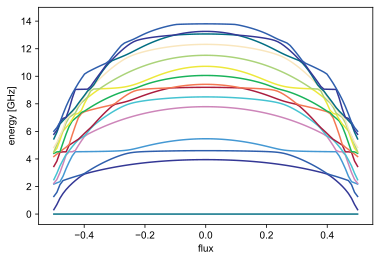

In [11]:
splot.dressed_spectrum(sweep);